# Affine Rectification Demo using Graph-Cut RANSAC

This notebook demonstrates planar affine rectification using:
1. Scale features extracted from SIFT keypoints, orientation features extracted from SIFT and Line Segment Detector (LSD).
1. Our proposed hybrid RANSAC framework based on the `pygcransac` library.

## Setup Instructions

Before running this notebook, please set up your environment:

```bash
# 1. Create and activate virtual environment
python -m venv venv
source venv/bin/activate

# 2. Install dependencies
pip install -r requirements.txt

# 3. Fix pylsd for Python 3
python scripts/fix_pylsd.py

# 4. Install pygcransac from source
pip install .

# 5. Launch Jupyter
jupyter notebook examples/
```

In [15]:
import cv2
import pygcransac
import numpy as np
from pylsd.lsd import lsd
import matplotlib.pyplot as plt
from utils import *

# Set matplotlib figure size for better visualization
plt.rcParams['figure.figsize'] = [18, 9]

## Load Input Image

Load and display the input image. Replace the path below with your own image.


✓ Successfully loaded image from img/tiled_floor_001.jpg
  Image size: 1368x1824


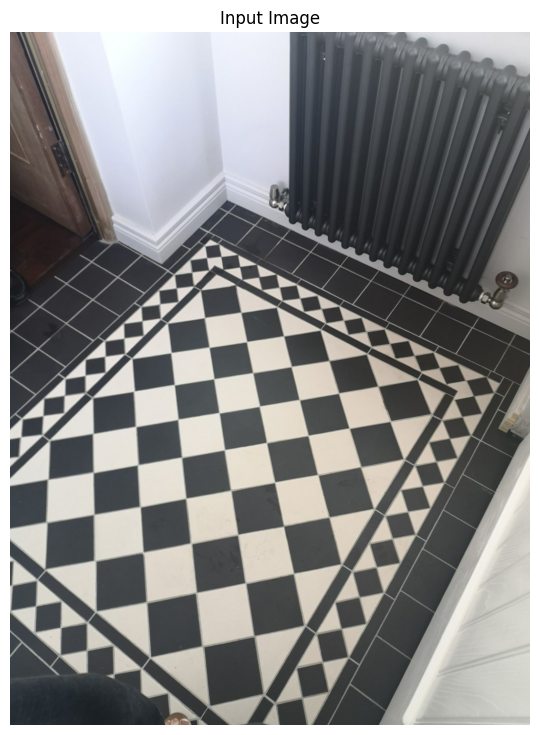

In [16]:
# Load image (replace with your own image path)
IMAGE_PATH = 'img/tiled_floor_001.jpg'  # Change this to your image path

color_img = cv2.imread(IMAGE_PATH)
if color_img is None:
    raise FileNotFoundError(
        f"Could not load image from '{IMAGE_PATH}'.\n"
        "Please provide a valid image path in the IMAGE_PATH variable.\n"
        "Suggested images: tiled floor, brick wall, checkerboard pattern, etc."
    )

# Convert from BGR to RGB for matplotlib display
color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)
print(f"✓ Successfully loaded image from {IMAGE_PATH}")
print(f"  Image size: {color_img.shape[1]}x{color_img.shape[0]}")

# Display the image
plt.imshow(color_img)
plt.axis('off')
plt.title('Input Image')
plt.show()

# Convert to grayscale for processing
gray_img = cv2.cvtColor(color_img, cv2.COLOR_RGB2GRAY)


## Feature Detection

Detect scale and orientation features using SIFT and LSD detectors.

### SIFT Keypoints Detection

Detect SIFT keypoints and visualize them.

Detected 1000 SIFT keypoints


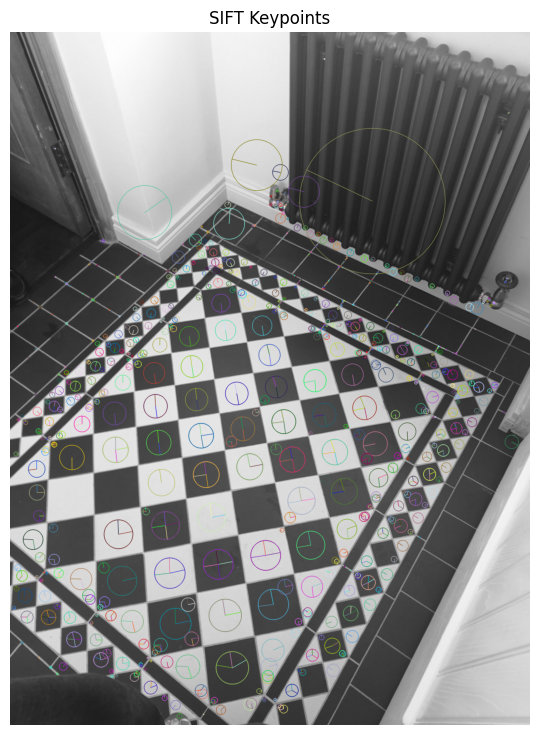

In [17]:
# Detect SIFT keypoints with a size threshold
sift = cv2.SIFT_create(1000)
sift_keypoints = [kp for kp in list(sift.detect(gray_img, None))]

print(f"Detected {len(sift_keypoints)} SIFT keypoints")

# Visualize keypoints
keypoints_img = cv2.drawKeypoints(
    gray_img, sift_keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

plt.imshow(keypoints_img, cmap='gray')
plt.axis('off')
plt.title('SIFT Keypoints')
plt.show()


### Extract Unique Scale Features and Orientation Features from SIFT Keypoints

Create scale features from SIFT keypoints:
1. Coordinates are keypoints' coordinates.
2. Scales are keypoint's sizes.
3. A single coordinate (x, y) can have multiple keypoints with the same scale and up to four different orientations. We extract one scale feature for each unique coordinate.

Create orientation feature from SIFT keypoints:
1. Coordinates are keypoints' coordinates.
2. Orientations are keypoints' angles converted to radians.
3. Keypoints with invalid angles (equal to -1) are disregarded.

** We filter out keypoints with small sizes to decrease noisy detection.

In [18]:
# Filter out keypoints with small sizes
sift_keypoints = [kp for kp in sift_keypoints if kp.size > 30]

# Extract unique scale features
scale_features = scale_features_from_sift(sift_keypoints)
print(f"Number of SIFT-based scale features: {scale_features.shape[0]}")

sift_orientation_features, sift_orientation_sizes = orientation_features_from_sift(sift_keypoints)
print(f"Number of SIFT-based orientation features: {sift_orientation_features.shape[0]}")

Number of SIFT-based scale features: 103
Number of SIFT-based orientation features: 198


### Visualize SIFT-Based Scale and Orientation Features

Display the extracted scale and orientation features side-by-side.

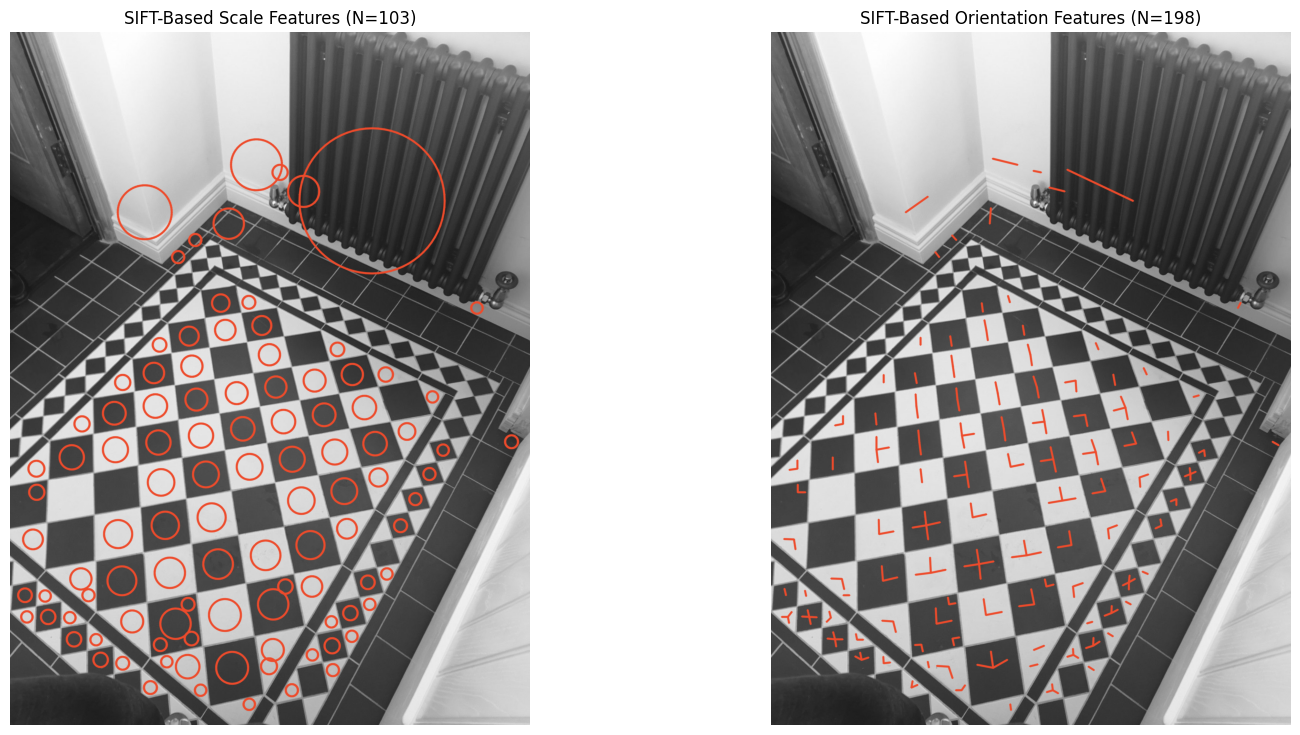

In [19]:
# Create copies of grayscale image for visualization
scale_features_img = cv2.cvtColor(gray_img.copy(), cv2.COLOR_GRAY2RGB)
sift_orientation_features_img = cv2.cvtColor(gray_img.copy(), cv2.COLOR_GRAY2RGB)

# Draw scale features (circles) in red/orange color
draw_scale_features(scale_features_img, scale_features, (238, 75, 43), thickness=4)

# Draw orientation features (lines) in red/orange color
draw_orientation_features(
    sift_orientation_features_img, sift_orientation_features, sift_orientation_sizes, 
    (238, 75, 43), thickness=4
)

# Display side-by-side
fig, ax = plt.subplots(1, 2, figsize=(18, 9))
ax[0].imshow(scale_features_img)
ax[0].axis('off')
ax[0].set_title(f'SIFT-Based Scale Features (N={scale_features.shape[0]})')
ax[1].imshow(sift_orientation_features_img)
ax[1].axis('off')
ax[1].set_title(f'SIFT-Based Orientation Features (N={sift_orientation_features.shape[0]})')
plt.show()


### Line Segment Detection

Detect line segments using Line Segment Detector (LSD) and visualize them.

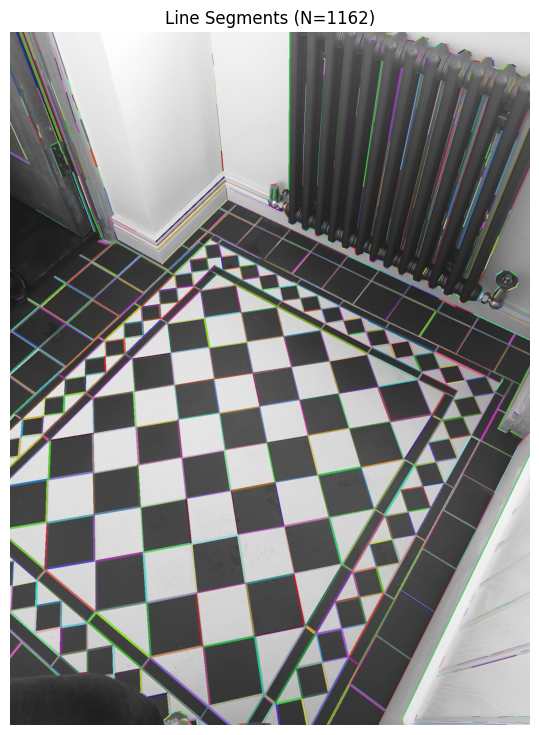

In [20]:
# Detect line segments
detected_lines = lsd(gray_img)

COLOR_MARGIN = 30 # used to ensure that only colors that are not too bright or too dark are displayed
# Display line segments
line_img = cv2.cvtColor(gray_img.copy(), cv2.COLOR_GRAY2BGR)
for seg in detected_lines:
    # extract image lines
    pt1 = np.array([int(seg[0]), int(seg[1])])
    pt2 = np.array([int(seg[2]), int(seg[3])])        
    width = int(np.ceil(seg[4] / 4))
    color = np.random.randint(low=COLOR_MARGIN, high=256-COLOR_MARGIN, size=(3,)).tolist()
    cv2.line(line_img, pt1, pt2, color, width)

plt.imshow(line_img)
plt.axis('off')
plt.title(f'Line Segments (N={len(detected_lines)})')
plt.show()

### Create Orientation Features from Line Segments

Create orientation features from line segments:
1. Coordinates are the midpoints of the line segments.
2. Orientation are the orientation of the line segments.
3. Setting a minimum length to filter out small line segments.

In [21]:
min_ls_length = 30

# Filter by minimum length and extract orientation features
lsd_orientation_features = []
lsd_orientation_sizes = []
for line in detected_lines:
    x1, y1, x2, y2 = line[0], line[1], line[2], line[3]
    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    if length >= min_ls_length:
        # Midpoint of line segment
        x_mid = (x1 + x2) / 2
        y_mid = (y1 + y2) / 2
        # Orientation of line segment
        angle = np.arctan2(y2 - y1, x2 - x1)
        lsd_orientation_features.append([x_mid, y_mid, angle])
        lsd_orientation_sizes.append(0.5 * length)

lsd_orientation_features, lsd_orientation_sizes = np.array(lsd_orientation_features), np.array(lsd_orientation_sizes)
print(f"Number of LSD-based orientation features: {lsd_orientation_features.shape[0]}")


Number of LSD-based orientation features: 714


### Visualize LSD-Based Orientation Features

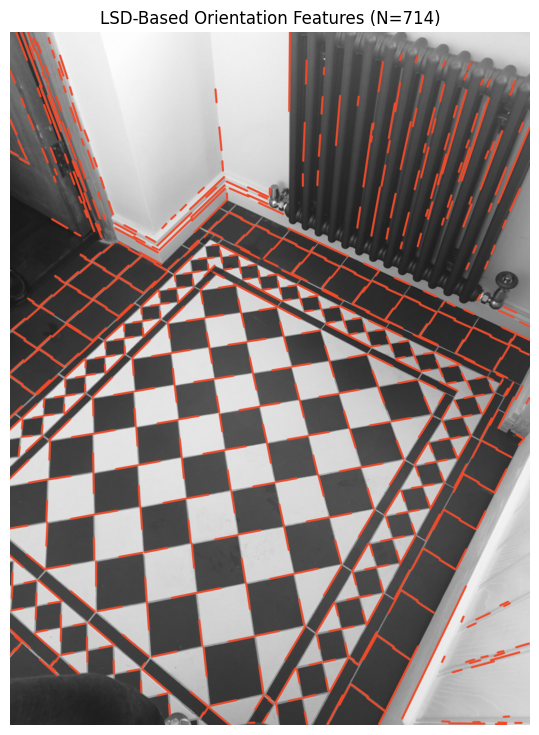

In [22]:
# Visualize orientation features
lsd_orientations_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
draw_orientation_features(
    lsd_orientations_img, lsd_orientation_features, lsd_orientation_sizes,
    (238, 75, 43), thickness=4
)

plt.imshow(lsd_orientations_img)
plt.axis('off')
plt.title(f'LSD-Based Orientation Features (N={lsd_orientation_features.shape[0]})')
plt.show()

## Combine Features and Visualize

Combine SIFT and LSD orientation features, then visualize them.


Total orientation features: 912


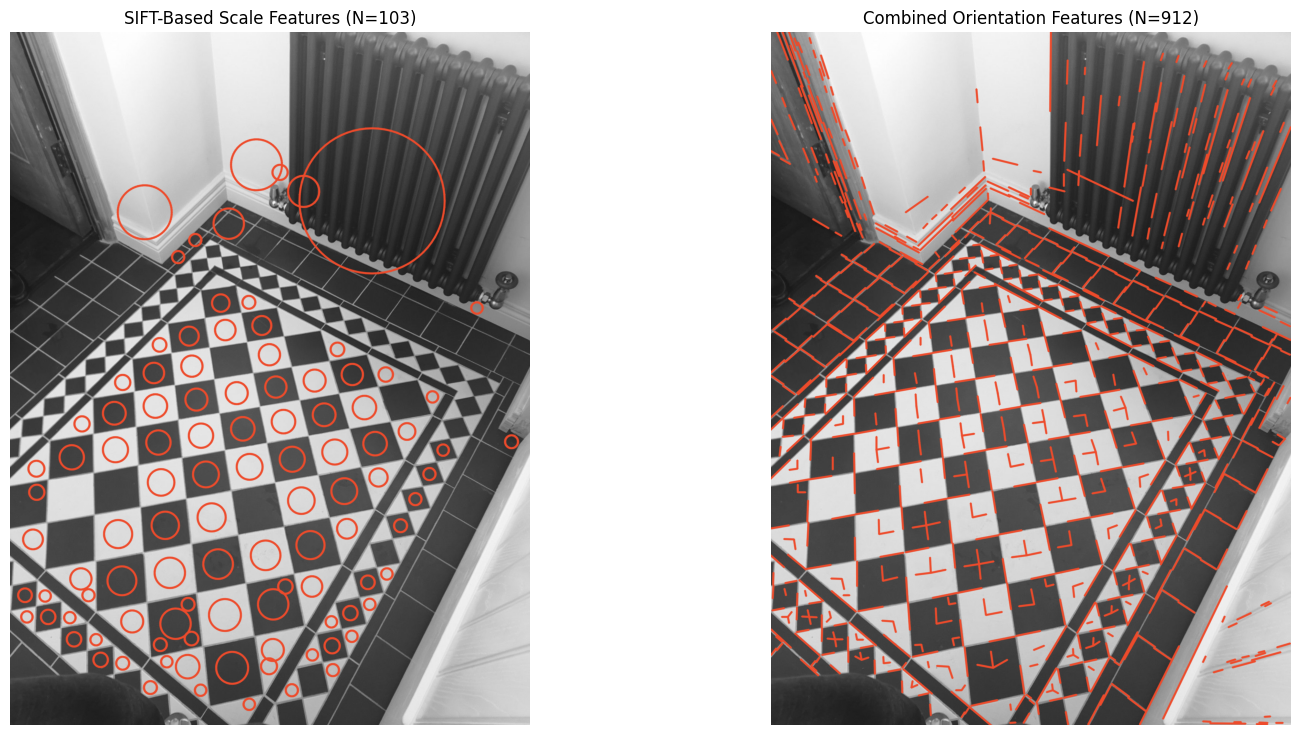

In [23]:
# Combine SIFT and LSD orientation features
orientation_features = np.vstack([sift_orientation_features, lsd_orientation_features])
orientation_sizes = np.hstack([sift_orientation_sizes, lsd_orientation_sizes])
print(f"Total orientation features: {orientation_features.shape[0]}")

# Visualize combined features
orientation_feature_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
draw_orientation_features(
    orientation_feature_img, orientation_features, orientation_sizes, (238, 75, 43), thickness=4
)

fig, ax = plt.subplots(1, 2, figsize=(18, 9))
ax[0].imshow(scale_features_img) # Only SIFT-based scale features are used
ax[0].axis('off')
ax[0].set_title(f'SIFT-Based Scale Features (N={scale_features.shape[0]})')
ax[1].imshow(orientation_feature_img)
ax[1].axis('off')
ax[1].set_title(f'Combined Orientation Features (N={orientation_features.shape[0]})')
plt.show()


## Estimate Rectifying Homography using PyGCRANSAC

Use the Graph-Cut RANSAC algorithm to estimate the rectifying homography.


In [24]:
# PyGCRANSAC hyperparameters
scale_thresh = np.log(1.05)               # Scale threshold
orientation_thresh = np.deg2rad(1.0)      # Orientation threshold (in radians)
spatial_coherence_weight = 0.0            # Spatial coherence weight
min_iter_num = 5000                       # Minimum iterations
max_iter_num = 5000                       # Maximum iterations
max_local_opt_num = 50                    # Maximum local optimization iterations

# Estimate rectifying homography
print("Running PyGCRANSAC...")
est_warping_homography, scale_inliers, orientation_inliers, model = \
    pygcransac.findRectifyingHomographySIFT(
        np.ascontiguousarray(scale_features),
        np.ascontiguousarray(orientation_features),
        scale_thresh,
        orientation_thresh,
        spatial_coherence_weight,
        min_iter_num,
        max_iter_num,
        max_local_opt_num
    )

# Print results
print(f"\nNumber of scale inliers/outliers: {np.sum(scale_inliers)} / {np.sum(~scale_inliers)}")
print(f"Number of orientation inliers/outliers: {np.sum(orientation_inliers)} / {np.sum(~orientation_inliers)}")
print(f"\nEstimated warping homography:\n{est_warping_homography}")
print(f"\nModel parameters:")
print(f"  alpha: {model.alpha:.6f}")
print(f"  Vanishing point direction: {np.rad2deg(model.phi):.2f}°")


Running PyGCRANSAC...

Number of scale inliers/outliers: 42 / 61
Number of orientation inliers/outliers: 209 / 703

Estimated warping homography:
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 3.40991093e-05 -2.36709075e-04  1.00000000e+00]]

Model parameters:
  alpha: 0.307263
  Vanishing point direction: 174.16°


## Apply Rectification

Apply the estimated homography to rectify the image.


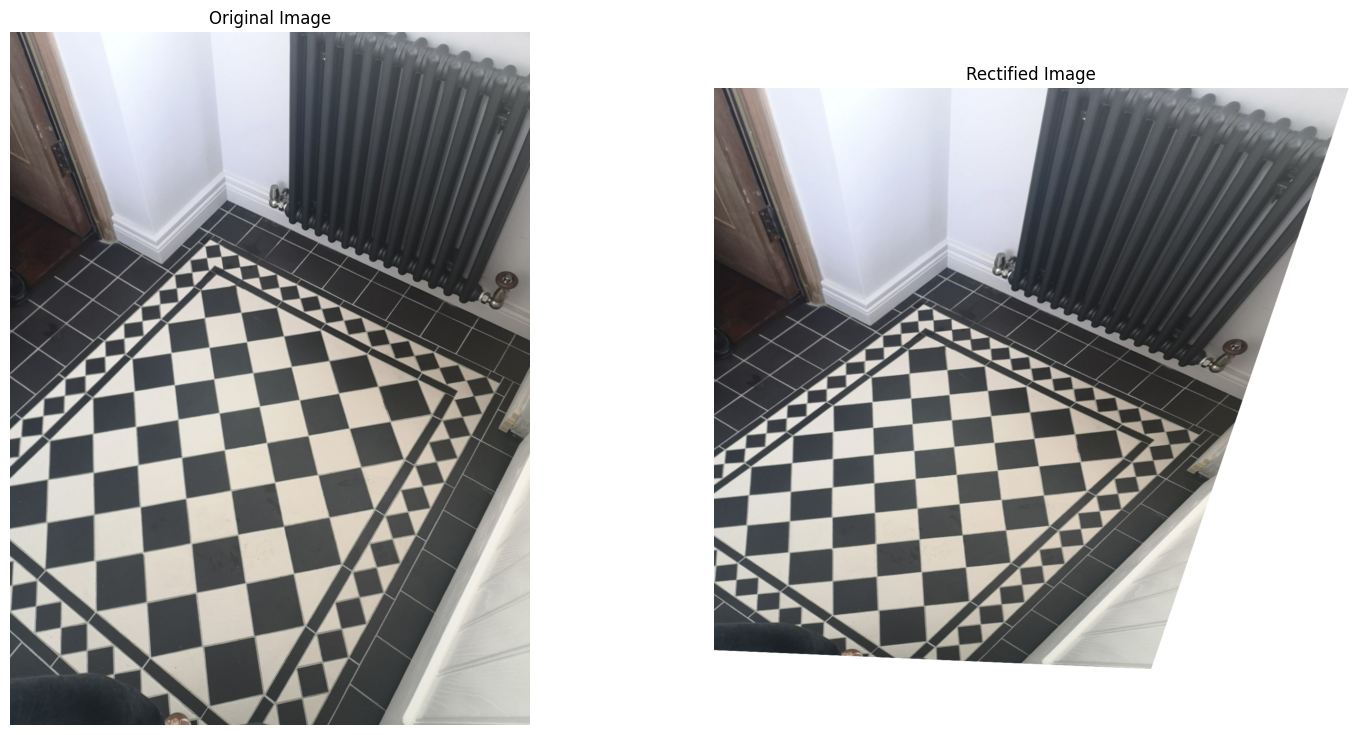

In [25]:
# Compute rectifying homography (inverse of warping homography)
est_rectifying_homography = np.linalg.inv(est_warping_homography)

# Apply rectification to grayscale and color images
est_rectified_img, _, _ = perspective_warp(gray_img, est_rectifying_homography)
est_color_rect_img, _, _ = perspective_warp(color_img, est_rectifying_homography)

# Display rectified images
fig, ax = plt.subplots(1, 2, figsize=(18, 9))
ax[0].imshow(color_img)
ax[0].axis('off')
ax[0].set_title('Original Image')
ax[1].imshow(est_color_rect_img)
ax[1].axis('off')
ax[1].set_title('Rectified Image')
plt.show()


## Visualize Inliers and Outliers

Show which scale features were classified as inliers vs outliers.


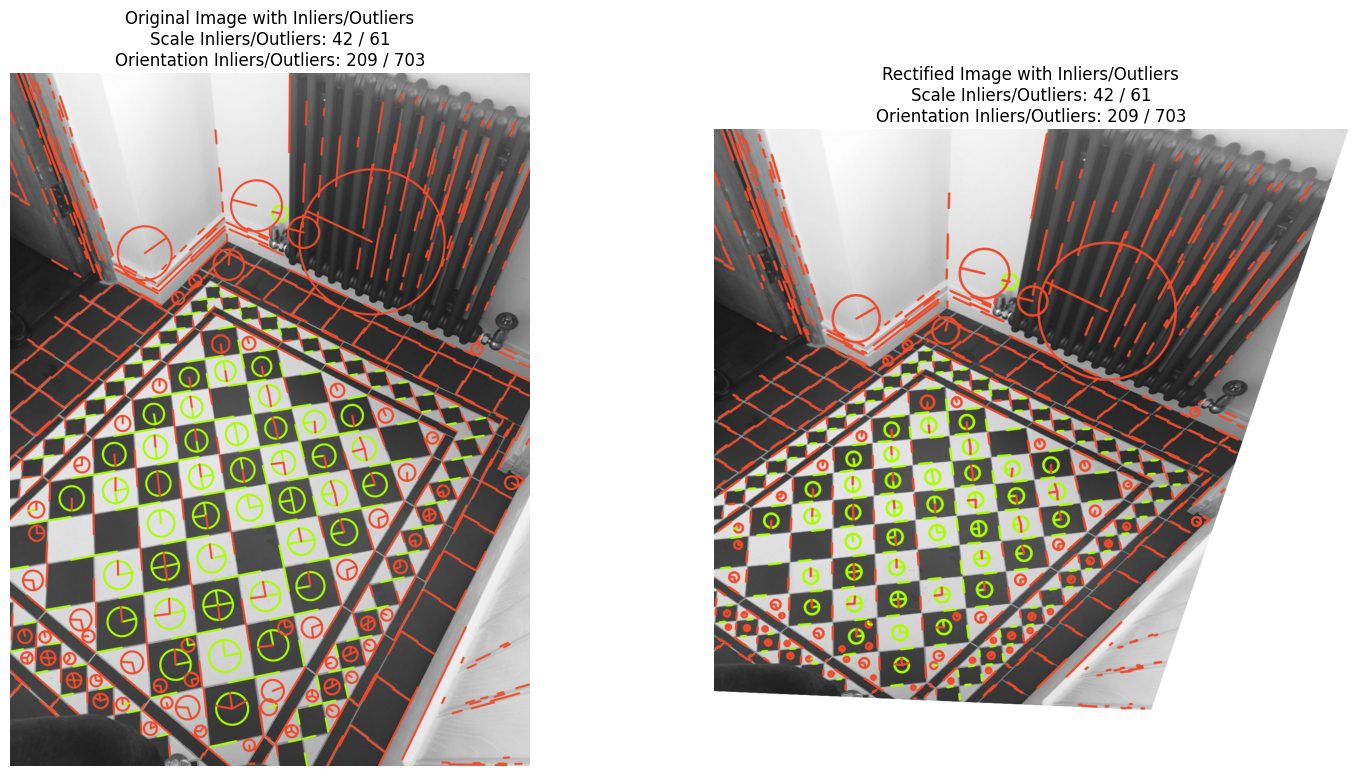

In [26]:
# Visualize scale inliers and outliers on original image
inlier_color = (170, 255, 0)   # Green
outlier_color = (238, 75, 43)  # Red

inlier_outlier_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
draw_scale_features(
    inlier_outlier_img, scale_features[scale_inliers], inlier_color, thickness=4
)
draw_scale_features(
    inlier_outlier_img, scale_features[~scale_inliers], outlier_color, thickness=4
)
draw_orientation_features(
    inlier_outlier_img, orientation_features[orientation_inliers], orientation_sizes[orientation_inliers],
    inlier_color, thickness=4
)
draw_orientation_features(
    inlier_outlier_img, orientation_features[~orientation_inliers], orientation_sizes[~orientation_inliers],
    outlier_color, thickness=4
)

# Compute rectified scale features
rectified_scale_features = np.zeros_like(scale_features)
for i in range(scale_features.shape[0]):
    x, y, scale = scale_features[i, 0], scale_features[i, 1], scale_features[i, 2]
    rectified_scale_features[i, 2] = model.rectifiedScale(x, y, scale)
    x_rect, y_rect = model.rectifiedPoint(x, y)
    rectified_scale_features[i, 0] = x_rect
    rectified_scale_features[i, 1] = y_rect

# Compute rectified orientation features
rectified_orientation_features = np.zeros_like(orientation_features)
rectified_orientation_sizes = np.zeros_like(orientation_sizes)
for i in range(orientation_features.shape[0]):
    x, y, orientation = orientation_features[i, 0], orientation_features[i, 1], orientation_features[i, 2]
    rectified_orientation_features[i, 2] = model.rectifiedAngle(x, y, orientation)
    rectified_orientation_sizes[i] = model.rectifiedScale(x, y, orientation_sizes[i])
    x_rect, y_rect = model.rectifiedPoint(x, y)
    rectified_orientation_features[i, 0] = x_rect
    rectified_orientation_features[i, 1] = y_rect

# Visualize rectified scale inliers and outliers
rectified_inliers_img = cv2.cvtColor(est_rectified_img, cv2.COLOR_GRAY2RGB)
draw_scale_features(
    rectified_inliers_img, rectified_scale_features[scale_inliers], inlier_color, thickness=4
)
draw_scale_features(
    rectified_inliers_img, rectified_scale_features[~scale_inliers], outlier_color, thickness=4
)
draw_orientation_features(
    rectified_inliers_img, rectified_orientation_features[orientation_inliers], rectified_orientation_sizes[orientation_inliers],
    inlier_color, thickness=4
)
draw_orientation_features(
    rectified_inliers_img, rectified_orientation_features[~orientation_inliers], rectified_orientation_sizes[~orientation_inliers],
    outlier_color, thickness=4
)
# Display inliers/outliers
fig, ax = plt.subplots(1, 2, figsize=(18, 9))
ax[0].imshow(inlier_outlier_img)
ax[0].axis('off')
ax[0].set_title(f'Original Image with Inliers/Outliers\nScale Inliers/Outliers: {np.sum(scale_inliers)} / {np.sum(~scale_inliers)}\nOrientation Inliers/Outliers: {np.sum(orientation_inliers)} / {np.sum(~orientation_inliers)}')
ax[1].imshow(rectified_inliers_img)
ax[1].axis('off')
ax[1].set_title(f'Rectified Image with Inliers/Outliers\nScale Inliers/Outliers: {np.sum(scale_inliers)} / {np.sum(~scale_inliers)}\nOrientation Inliers/Outliers: {np.sum(orientation_inliers)} / {np.sum(~orientation_inliers)}')
plt.show()
